# Text in Daten umwandeln


In [ ]:
# Vorweg paar Dependencies die wir in diesem Notebook brauchen werden:
import matplotlib.pyplot as plt
from collections import Counter


Das Analysieren von Text ist die Kernaufgabe von LLM-Tools wie ChatGPT.

Hierfür schauen wir uns mal ein einfaches Sprachmodell an, ein sogenanntes n-gram-Modell.

Ein n-gram ist eine Sequenz aus n Wörtern, wobei n unspezifisch ist.

n-gram-Sprachmodelle nutzen Wahrscheinlichkeiten, um das wahrscheinlichste nächste Wort
zu generieren.

Als Beispiel nehmen wir hierfür einen Text aus Projekt Gutenberg: [Der gestiefelte Kater, Kapitel 1](https://www.projekt-gutenberg.org/avenariu/kater/chap001.html), von [Ferdinand Avenarius](https://www.projekt-gutenberg.org/autoren/namen/avenariu.html)

In [1]:
filename = "./data/der-gestiefelte-kater.txt"
reader = open(filename)

# Zeilenweise einlesen
lines = reader.readlines()

# die erste Zeile ausgeben
print(lines[0])
print("%d Zeilen" % len(lines))

Der gestiefelte Kater

320 Zeilen


## Zählen von Wörtern

Wichtig für unser Modell sind die Statistiken. Wir zählen, wieviele Wörter es gibt,
wie oft kommt ein Wort wiederholt vor, und was ist das meistverwendete Wort? 

Um die Wahrscheinlichkeiten auszurechnen,
welches Wort am wahrscheinlichsten dem vorangegangenem Wort folgt, ist es
außerdem notwendig, sich Wortpaare anzuschauen.

Als ersten Schritt nehmen wir jede Zeile, entfernen Satzzeichen und verwenden die `string.split()` API.

In [28]:
def clean_words(words):
    return [cleaned_word for cleaned_word in [word.strip("\"'*@_.,!?$%&/\-#") for word in words] if len(cleaned_word) > 0]

line = "Komm, ... wir essen, Opa!"
words = line.split()
schlecht_fuer_opa =  clean_words(words)
print("Satz, zerteilt:", words)
print("Satz, zerteilt und ohne Satzzeichen:", schlecht_fuer_opa)

Satz, zerteilt: ['Komm,', '...', 'wir', 'essen,', 'Opa!']
Satz, zerteilt und ohne Satzzeichen: ['Komm', 'wir', 'essen', 'Opa']


Die Satzzeichen bleiben erhalten. Das ist gut für Opa, aber schlecht für unser Sprachmodell. Wir können Satzzeichen über die `string.strip`-API herausfiltern. Dann gibt es noch die `string.split()`-API. Sie liefert uns ein Array zurück, und die Anzahl der Wörter in diesem Array können wir via `len()` bestimmen.

In [32]:
word_count = 0
print(clean_words(lines[5].split()))
for line in lines:
  word_count += len(clean_words(line.split()))

print("%d Wörter" % word_count)

['vorbei', 'trübselig', 'saß', 'er', 'nun', 'bei', 'Wasser', 'und', 'Brot', 'Neben', 'ihm', 'lag', 'der', 'Hinze', 'und']
3746 Wörter


Das allein hilft uns jedoch noch nicht soviel weiter. Wir wollen wissen, welches Wort wie häufig vorkommt, um daraus Wahrscheinlichkeiten für unser Sprachmodell zu errechnen. Dafür kommt ein Counter zum Einsatz. Ein Counter funktioniert
so ähnlich wie ein Dictionary, nur dass nicht vorhandene Keys keinen Fehler zurückgeben sondern 0. So spart man sich die
if-Abfrage, ob ein key existiert.

In [37]:

def make_dict(lines):
    word_dict = Counter()
    for line in lines:
        for word in clean_words(line.lower().split()):
            word_dict[word] += 1
            
    return word_dict

Testen wir das ganze mal mit einem ganz kleinen Text:

In [38]:
print(make_dict(["Hallo, dies ist ein Test", "das ist ein sehr cooler Test."]))

Counter({'ist': 2, 'ein': 2, 'test': 2, 'hallo': 1, 'dies': 1, 'das': 1, 'sehr': 1, 'cooler': 1})


Und wie sieht der Dictionary-Datensatz für den gestiefelten Kater aus? Nun, es sind schon sehr viele Wörter. Glücklicherweise gibt es eine `Counter().most_common()`-API. So lassen sich die Top-10 der häufigsten Wörter gut visualisieren.

1301 Wörter. Die 10 häufigsten sind:


<BarContainer object of 10 artists>

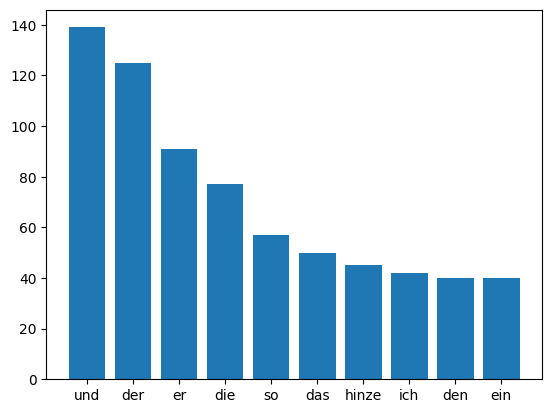

In [42]:
frequency_dict = make_dict(lines) 
top10 = frequency_dict.most_common(10)

print("%d Wörter. Die 10 häufigsten sind:" % len(frequency_dict))

keys = [k for k, _ in top10]
vals = [v for _, v in top10]

plt.bar(keys, vals)

Das Zählen der Wort-Vorkommen ist eine wichtige Grundlage. Als nächstes können wir damit ein einfaches Language Model implementieren.
Fast. Was noch fehlt, ist das Zählen der Wortpaare. Dazu iterieren wir zeile für Zeile und erstellen ein 2-Wort-Fenster. Wir nutzen für unsere Objekt-Keys `tuple()`, da immutable Keys benötigt werden.

In [2]:
from collections import Counter

def count_bigrams(lines):
    punctuation = '.;,-"“’”:?—‘!()_'
    window = []
    bigram_counter = Counter()
    for line in lines:
        sentence = line.split()
        for word in sentence:
            cleaned_word = word.strip(punctuation).lower()
            window.append(cleaned_word)
            if len(window) >= 2:
                window_tuple = tuple(window)
                bigram_counter[window_tuple] +=1 
                window.pop(0)
    
    return bigram_counter

print(count_bigrams([lines[3], lines[4], lines[5]]))

Counter({('für', 'den'): 2, ('den', 'jüngsten'): 2, ('der', 'dünne'): 1, ('dünne', 'friedrich'): 1, ('friedrich', 'den'): 1, ('den', 'esel'): 1, ('esel', 'aber'): 1, ('aber', 'für'): 1, ('jüngsten', 'war'): 1, ('war', 'gar'): 1, ('gar', 'nichts'): 1, ('nichts', 'übrig'): 1, ('übrig', 'geblieben'): 1, ('geblieben', 'als'): 1, ('als', 'der'): 1, ('der', 'kater'): 1, ('kater', 'also'): 1, ('also', 'waren'): 1, ('waren', 'die'): 1, ('die', 'guten'): 1, ('guten', 'tage'): 1, ('tage', 'für'): 1, ('jüngsten', 'den'): 1, ('den', 'hans'): 1, ('hans', 'vorbei'): 1, ('vorbei', 'trübselig'): 1, ('trübselig', 'saß'): 1, ('saß', 'er'): 1, ('er', 'nun'): 1, ('nun', 'bei'): 1, ('bei', 'wasser'): 1, ('wasser', 'und'): 1, ('und', 'brot'): 1, ('brot', 'neben'): 1, ('neben', 'ihm'): 1, ('ihm', 'lag'): 1, ('lag', 'der'): 1, ('der', 'hinze'): 1, ('hinze', 'und'): 1})
